# Deep Neural Networks

In [ ]:
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
from sklearn.metrics     import confusion_matrix
from scipy               import stats

%load_ext autoreload
%autoreload 1
%aimport nn_model
%aimport create_data
%aimport preprocess
%aimport plot_utils

## Define useful functions

In [ ]:
def plot_data(x, y, title):
    fig = plt.figure(figsize=(5,5))
    if x.shape[1] == 2:
        ax = plt.axes()
        ax.scatter(x[:,0], x[:,1], c=y)
    elif x.shape[1] == 3:
        ax = plt.axes(projection='3d')
        ax.scatter3D(x[:,0], x[:,1], x[:,2], c=y, alpha=0.3)
    ax.set_title(title)
    plt.show()

def network_perf(fit):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

    ax[0].plot(fit.history['accuracy'],label="train")
    ax[0].plot(fit.history['val_accuracy'],label="valid.")
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(fit.history['loss'],label="train")
    ax[1].plot(fit.history['val_loss'],label="valid.")
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel("Loss")
    ax[1].legend()

    plt.show()

def pred_comp(x, y, network):
    pred = network.predict(x)
    # if pred-label > 0.5 ==> pred-label==1
    pred_binary = pred.copy()
    pred_binary[pred <= 0.5] = 0
    pred_binary[pred >  0.5] = 1

    # plots
    if x.shape[1] == 2:
        fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(16,5))
        # real data
        ax[0].scatter(x[:,0], x[:,1], c=y)
        # NN prediction
        ax[1].scatter(x[:,0], x[:,1], c=pred)
        # hard NN prediction
        ax[2].scatter(x[:,0], x[:,1], c=pred_binary)
    elif x.shape[1] == 3:
        fig = plt.figure(figsize=(16,5))
        ax = (fig.add_subplot(1, 3, 1, projection='3d'),
              fig.add_subplot(1, 3, 2, projection='3d'),
              fig.add_subplot(1, 3, 3, projection='3d'))
        ax[0].scatter3D(x[:,0], x[:,1], x[:,2], c=y, alpha=0.3)
        ax[1].scatter3D(x[:,0], x[:,1], x[:,2], c=pred, alpha=0.3)
        ax[2].scatter3D(x[:,0], x[:,1], x[:,2], c=pred_binary, alpha=0.3)
    
    ax[0].set_title("real data")
    ax[1].set_title("NN prediction")
    ax[2].set_title("hard NN prediction")
    plt.show()

def best_net(dim, name):
    # NN hyperparameters
    architecture      = [dim, 20, 20, 1]
    dropout_arc       = [1]
    dropout_rates     = [0.2]
    batch_norm_arc    = [2]   
    input_dim         = architecture[0]
    hidden_activation = "relu"
    output_activation = "sigmoid"

    # build the NN model
    network = nn_model.NN(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        nn_name           = name,
    )

    # print summary
    network.summary()

    # compile NN with loss, optimizer and metrics
    loss      = "binary_crossentropy"
    optimizer = "adam"
    metrics   = ["accuracy"]

    network.compile(
        loss      = loss,
        optimizer = optimizer,
        metrics   = metrics,
    )
    return network

## Trying different data
### 1) Circular data
#### 1.a) Generating

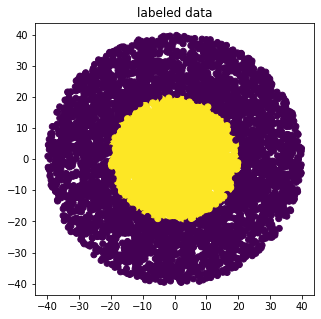

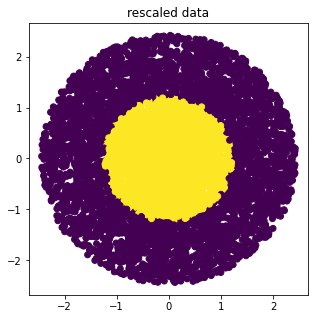

In [ ]:
# number of data
N = 8000
# box dim
B = 100

# random seed for reproducibility
np.random.seed(20220307)

x, y = create_data.create_data(N, B, c='rad')
# re-scaling data 
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)
x_scaled = preprocess.standardize(x, mean, std)

plot_data(x,y,'labeled data')
plot_data(x_scaled,y,'rescaled data')


#### 1.b) Dividing

In [ ]:
train_frac = 0.8
valid_frac = 0.2

N_train = int(N*train_frac)
training_data, training_labels = np.copy(x_scaled[0:N_train]), np.copy(y[0:N_train])
test_data,     test_labels     = np.copy(x_scaled[N_train:]),  np.copy(y[N_train:])

print(f"Traing set :\t{training_data.shape[0]}\nTest set  :\t{test_data.shape[0]}")

N_valid = int(N_train*valid_frac)
x_train, y_train = np.copy(training_data[N_valid:]),  np.copy(training_labels[N_valid:])
x_valid, y_valid = np.copy(training_data[0:N_valid]), np.copy(training_labels[0:N_valid])

print(f"\nN_train :\t{x_train.shape[0]} \nN_valid :\t{x_valid.shape[0]}")

Traing set :	6400
Test set  :	1600

N_train :	5120 
N_valid :	1280


#### 1.c) Defining network structure

In [ ]:
first_net = best_net(x_scaled.shape[1], 'circular data neural network')

Model: "circular data neural network"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_layer (InputLayer)                    [(None, 2)]                             0              
                                                                                                    
 hidden_0 (Dense)                            (None, 20)                              60             
                                                                                                    
 dropout_0 (Dropout)                         (None, 20)                              0              
                                                                                                    
 batch_norm_1 (BatchNormalization)           (None, 20)                              80             
                                                     

#### 1.d) Training

In [ ]:
minibatch = 100
N_epochs  = 300

first_fit = first_net.fit(
    x_train, y_train,
    epochs          = N_epochs,
    batch_size      = minibatch,
    validation_data = (x_valid, y_valid),
    verbose         = 0,
)

#### 1.e) Results

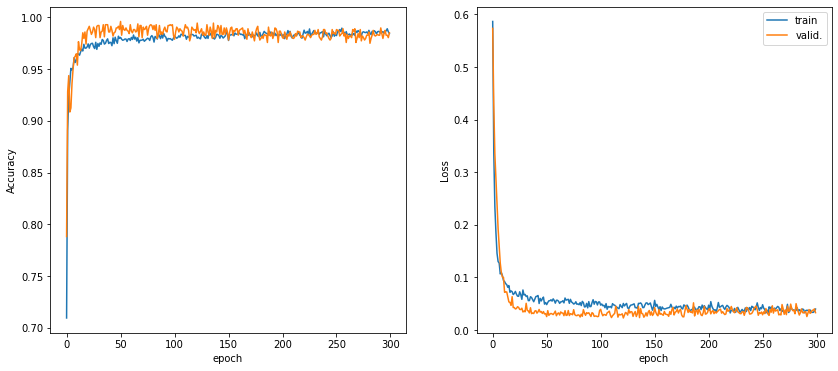

In [ ]:
network_perf(first_fit)

In [ ]:
test = first_net.evaluate(
    test_data, test_labels,
    batch_size      = minibatch,
    verbose         = 0,
)

print("test loss, test acc:", test)

test loss, test acc: [0.03018680401146412, 0.9868749976158142]


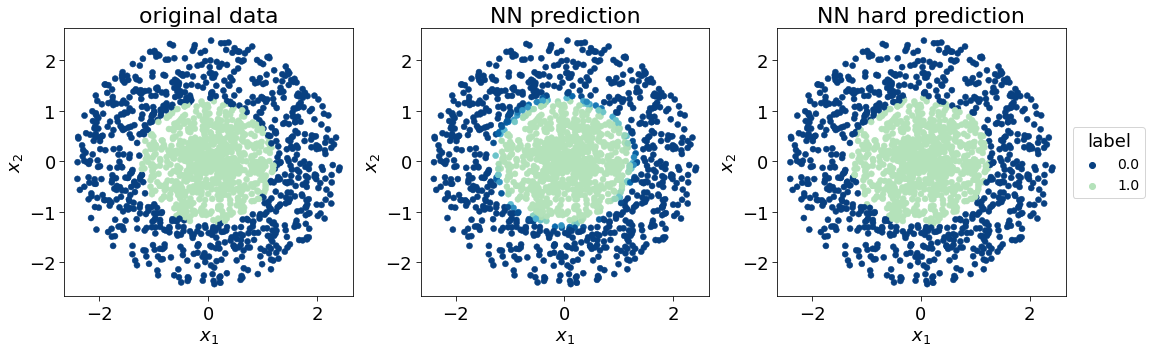

In [ ]:
plot_utils.plot_comparison(test_data, test_labels, first_net)

### 2) Non linear data
#### 2.a) Generating data


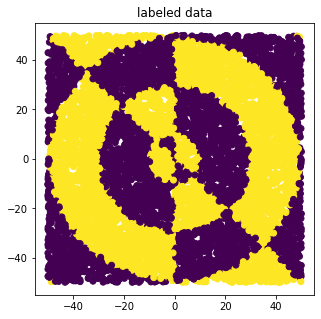

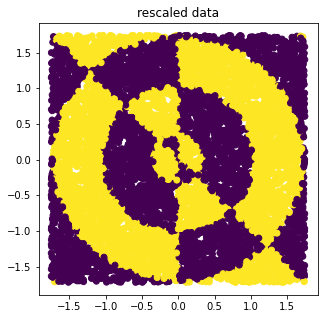

In [ ]:
# number of data
N = 8000
# box size
B = 100

x, y = create_data.create_data(N, B, c='weird')
# re-scaling data 
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)
x_scaled = preprocess.standardize(x, mean, std)

plot_data(x,y,'labeled data')
plot_data(x_scaled,y,'rescaled data')


#### 2.b) Dividing

In [ ]:
train_frac = 0.8
valid_frac = 0.4

N_train = int(N*train_frac)
N_valid = int(N_train*valid_frac)
weird_test  = (np.copy(x_scaled[N_train:]),       np.copy(y[N_train:]))
weird_train = (np.copy(x_scaled[N_valid:N_train]),np.copy(y[N_valid:N_train]))
weird_valid = (np.copy(x_scaled[0:N_valid]),      np.copy(y[0:N_valid]))

print(f"\nN_train :\t{weird_train[0].shape[0]} \nN_valid :\t{weird_valid[0].shape[0]} \nN_test  :\t{weird_test[0].shape[0]}")


N_train :	3840 
N_valid :	2560 
N_test  :	1600


#### 2.c) Defining DNN structure

In [ ]:
second_net = best_net(x_scaled.shape[1], 'weird data neural network')

Model: "weird data neural network"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_layer (InputLayer)                    [(None, 2)]                             0              
                                                                                                    
 hidden_0 (Dense)                            (None, 20)                              60             
                                                                                                    
 dropout_0 (Dropout)                         (None, 20)                              0              
                                                                                                    
 batch_norm_1 (BatchNormalization)           (None, 20)                              80             
                                                        

#### 2.d) Training

In [ ]:
minibatch = 100
N_epochs  = 300

second_fit = second_net.fit(
    weird_train[0], weird_train[1],
    epochs          = N_epochs,
    batch_size      = minibatch,
    validation_data = weird_valid,
    verbose         = 0,
)

#### 2.e) Results

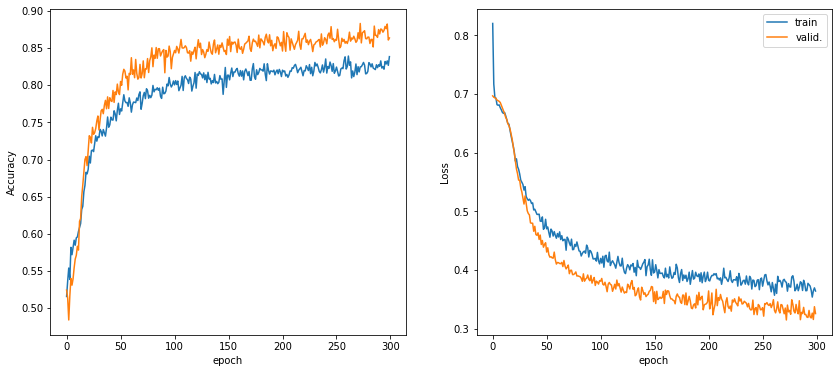

In [ ]:
network_perf(second_fit)

In [ ]:
test = second_net.evaluate(
    weird_test[0], weird_test[1],
    batch_size      = minibatch,
    verbose         = 0,
)

print("test loss, test acc:", test)

test loss, test acc: [0.37177619338035583, 0.8431249856948853]


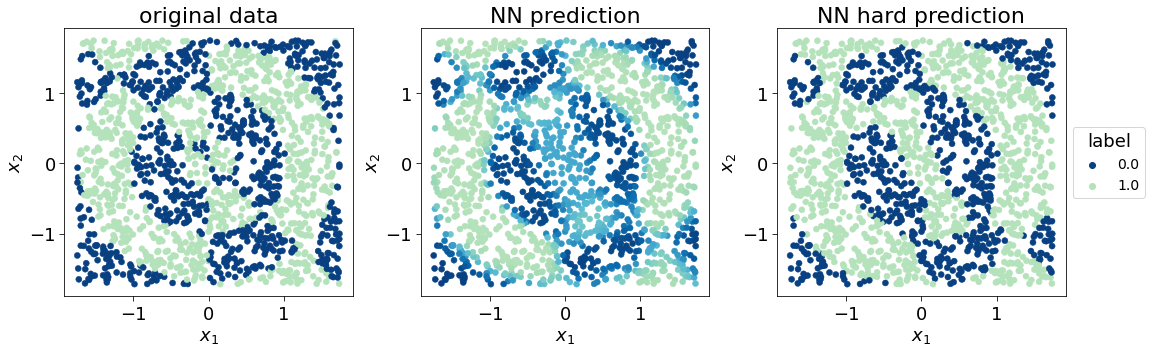

In [ ]:
plot_utils.plot_comparison(weird_test[0], weird_test[1], second_net)

### 3) Now in 3D!
#### 3.a) Generating data

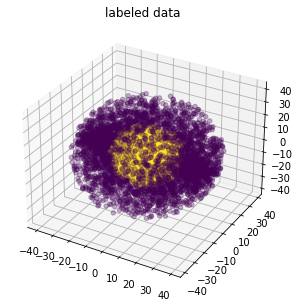

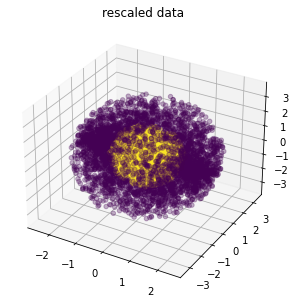

In [ ]:
# number of data
N = 8000
# box size
B = 100

x, y = create_data.create_data(N, B, c='radNd', dim=3)
# re-scaling data 
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)
x_scaled = preprocess.standardize(x, mean, std)

plot_data(x,y,'labeled data')
plot_data(x_scaled,y,'rescaled data')

#### 3.b) Dividing

In [ ]:
train_frac = 0.8
valid_frac = 0.4

N_train = int(N*train_frac)
training_data, training_labels = np.copy(x_scaled[0:N_train]), np.copy(y[0:N_train])
test_data,     test_labels     = np.copy(x_scaled[N_train:]),  np.copy(y[N_train:])

print(f"Traing set :\t{training_data.shape[0]}\nTest set  :\t{test_data.shape[0]}")

N_valid = int(N_train*valid_frac)
x_train, y_train = np.copy(training_data[N_valid:]),  np.copy(training_labels[N_valid:])
x_valid, y_valid = np.copy(training_data[0:N_valid]), np.copy(training_labels[0:N_valid])

print(f"\nN_train :\t{x_train.shape[0]} \nN_valid :\t{x_valid.shape[0]}")

Traing set :	6400
Test set  :	1600

N_train :	3840 
N_valid :	2560


#### 3.c) Defining DNN structure

In [ ]:
third_net = best_net(x_scaled.shape[1], '3d data neural network')

Model: "3d data neural network"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_layer (InputLayer)                    [(None, 3)]                             0              
                                                                                                    
 hidden_0 (Dense)                            (None, 20)                              80             
                                                                                                    
 dropout_0 (Dropout)                         (None, 20)                              0              
                                                                                                    
 batch_norm_1 (BatchNormalization)           (None, 20)                              80             
                                                           

#### 3.d) Training

In [ ]:
minibatch = 100
N_epochs  = 300

third_fit = third_net.fit(
    x_train, y_train,
    epochs          = N_epochs,
    batch_size      = minibatch,
    validation_data = (x_valid, y_valid),
    verbose         = 0,
)

#### 3.e) Results

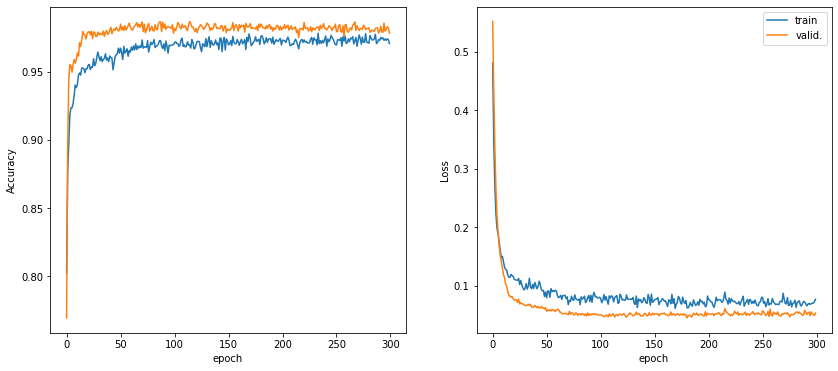

In [ ]:
network_perf(third_fit)

In [ ]:
test = third_net.evaluate(
    test_data, test_labels,
    batch_size      = minibatch,
    verbose         = 0,
)

print("test loss, test acc:", test)

test loss, test acc: [0.051361486315727234, 0.9768750071525574]


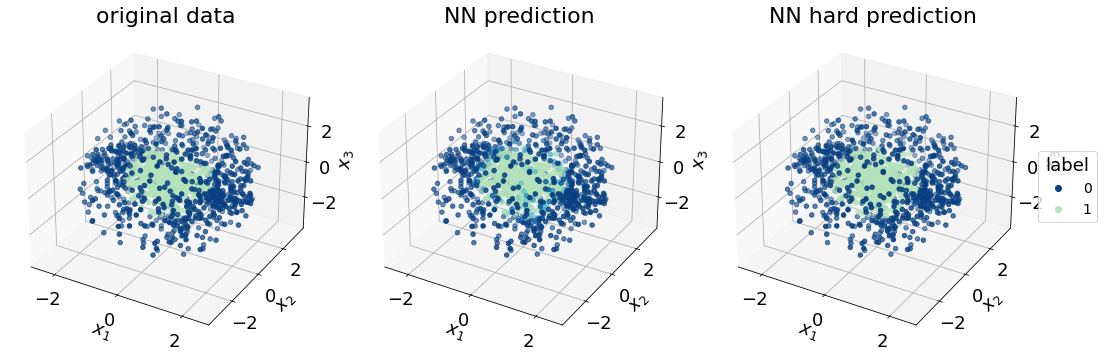

In [ ]:
plot_utils.plot_comparison(test_data, test_labels, third_net)

### 4) More dimensions?
#### 4.a) Generating data

In [ ]:
# number of data
N = 8000
# box size
B = 100
data_list = []
dims = np.arange(15, 21)

for i in dims:
    x, y = create_data.create_data(N, B, c='radNd', dim=i)
    # re-scaling data 
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    x_scaled = preprocess.standardize(x, mean, std)
    data_list.append((x_scaled, y))

#### 4.b) Dividing

In [ ]:
train_frac = 0.8
valid_frac = 0.4

N_train = int(N*train_frac)
N_valid = int(N_train*valid_frac)
test_list  = []
valid_list = []
train_list = []

for x, y in data_list:
    test_list.append((np.copy(x[N_train:]),  np.copy(y[N_train:])))
    train_list.append((np.copy(x[N_valid:N_train]),  np.copy(y[N_valid:N_train])))
    valid_list.append((np.copy(x[0:N_valid]), np.copy(y[0:N_valid])))

print(f"\nN_train :\t{train_list[0][0].shape[0]} \nN_valid :\t{valid_list[0][0].shape[0]}")


N_train :	3840 
N_valid :	2560


#### 4.c) Defining DNN structure

In [ ]:
net_list = [ best_net(train_list[i][0].shape[1], '{0}d data neural network'.format(dims[i])) for i in range(len(train_list))]

Model: "15d data neural network"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_layer (InputLayer)                    [(None, 15)]                            0              
                                                                                                    
 hidden_0 (Dense)                            (None, 20)                              320            
                                                                                                    
 dropout_0 (Dropout)                         (None, 20)                              0              
                                                                                                    
 batch_norm_1 (BatchNormalization)           (None, 20)                              80             
                                                          

#### 4.d) Training

In [ ]:
minibatch = 100
N_epochs  = 200

fit_list = [ net_list[i].fit(
             train_list[i][0], train_list[i][1],
             epochs          = N_epochs,
             batch_size      = minibatch,
             validation_data = (valid_list[i][0], valid_list[i][1]),
             verbose         = 0,
            ) for i in range(len(net_list)) ]


#### 4.e) Results

In [ ]:
for fit in fit_list:
    network_perf(fit)

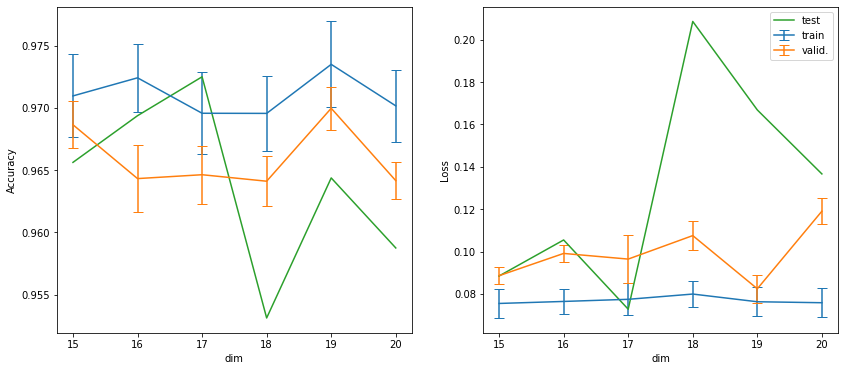

In [ ]:
test_array = np.asarray([net_list[i].evaluate(
                         test_list[i][0], test_list[i][1],
                         batch_size      = minibatch,
                         verbose         = 0) for i in range(len(net_list))])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax[0].errorbar(dims,[plot_utils.history_mode(fit_list[i].history['accuracy']) for i in range(len(fit_list))], 
               yerr=[np.asarray(fit_list[i].history['accuracy'])[-101:-1].std() for i in range(len(fit_list))], capsize=5, label="train")
ax[0].errorbar(dims,[plot_utils.history_mode(fit_list[i].history['val_accuracy']) for i in range(len(fit_list))], 
               yerr=[np.asarray(fit_list[i].history['val_accuracy'])[-101:-1].std() for i in range(len(fit_list))], capsize=5,label="valid.")
ax[0].plot(dims, test_array[:,1], label='test')
ax[0].set_xlabel('dim')
ax[0].set_ylabel("Accuracy")

ax[1].errorbar(dims,[plot_utils.history_mode(fit_list[i].history['loss']) for i in range(len(fit_list))], 
               yerr=[np.asarray(fit_list[i].history['loss'])[-101:-1].std() for i in range(len(fit_list))], capsize=5,label="train")
ax[1].errorbar(dims,[plot_utils.history_mode(fit_list[i].history['val_loss']) for i in range(len(fit_list))], 
               yerr=[np.asarray(fit_list[i].history['val_loss'])[-101:-1].std() for i in range(len(fit_list))], capsize=5,label="valid.")
ax[1].plot(dims, test_array[:,0], label='test')
ax[1].set_xlabel('dim')
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.show()

In [ ]:
hist, bins = np.histogram(np.asarray(fit_list[5].history['accuracy']), bins=100)
mode_n = hist.argmax()
(bins[mode_n]+bins[mode_n+1])/2

0.9701653683185576

plots: 
    - weird data real vs hard nn pred
    - confusion matrix
    - more dim?

## Plots
### Weird data

/work/LCP_modB/02-DNN/plot_utils.py:29: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


<AxesSubplot:title={'center':'Hard NN prediction'}, xlabel='$x_1$', ylabel='$x_2$'>

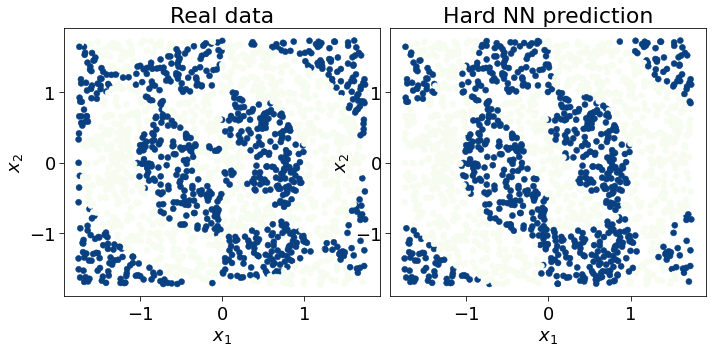

In [ ]:
weird_pred = second_net.predict(weird_test[0]).reshape((-1,))
weird_pred[weird_pred <= 0.5] = 0
weird_pred[weird_pred >  0.5] = 1

fig = plt.figure(figsize=(10,5), constrained_layout = True)

plot_utils.plot_labeled_data(
    weird_test[0], 
    weird_test[1], 
    fig, 
    subplot_id      = 121, 
    title           = "Real data", 
    legend          = False,
    palette         = 'GnBu_r',
    hue_norm        = (0, 2) )

plot_utils.plot_labeled_data(
    weird_test[0],
    weird_pred,
    fig,
    subplot_id    = 122,
    title         = "Hard NN prediction",
    legend        = False,
    palette         = 'GnBu_r',
    hue_norm        = (0, 2) )

<AxesSubplot:title={'center':'Weird data CM'}, xlabel='pred labels', ylabel='true labels'>

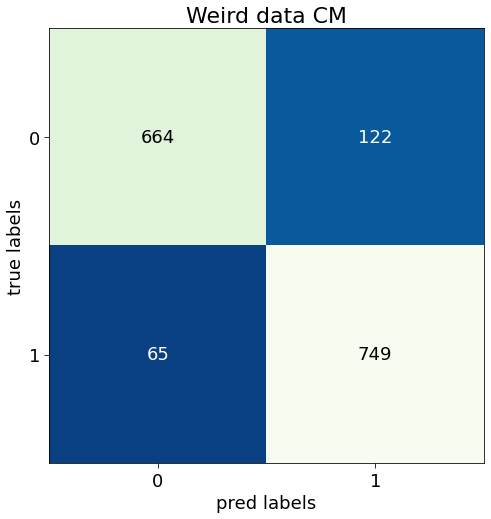

In [ ]:
cm = confusion_matrix( weird_test[1], weird_pred)
fig, ax = plt.subplots(1, 1, figsize=(8,8))


plot_utils.plot_confusion_matrix(
    cm,
    ax,
    cmap     = "GnBu_r",
    labels   = [0, 1],
    fontsize = 18,
    title    = 'Weird data CM',
)

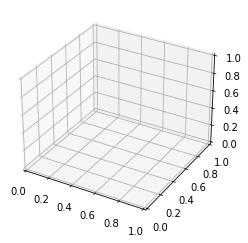

In [ ]:
dim =3
fig = plt.figure()
ax = fig.add_subplot(111, projection=('3d' if dim==3 else None))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>